In [1]:
import warnings
warnings.filterwarnings('ignore')
import time 
import logging 
import matplotlib.pyplot as plt 
import numpy as np 
import mxnet as mx 
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz

In [2]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.yolo import YOLO3DefaultTrainTransform
from gluoncv.data.dataloader import RandomTransformDataLoader
from gluoncv.utils import LRScheduler, LRSequential

In [3]:
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
gcv.utils.random.seed(233)

In [5]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

'pikachu_train.idx'

label: [[309.6292  205.79944 355.75494 274.14044   0.     ]]
shape: (512, 512, 3)


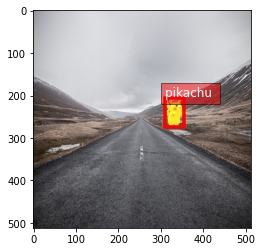

In [6]:
dataset = gcv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']
image, label = dataset[0]
print('label:', label)
print('shape:', image.shape)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)

plt.show()

In [21]:
dataset[1][1]

array([[214.70685, 132.91504, 271.07706, 215.32448,   0.     ]],
      dtype=float32)

In [7]:
net = gcv.model_zoo.get_model(
    'yolo3_darknet53_coco',
    pretrained=True,
)
net.reset_class(classes)

In [8]:
ctx = [mx.gpu()]
batch_size = 8

def get_dataloader(net, train_dataset, batch_size, num_workers):
    batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
    transform_fns = [YOLO3DefaultTrainTransform(x, x, net) for x in [320]]
    train_loader = RandomTransformDataLoader(
        transform_fns, train_dataset, batch_size=batch_size, interval=10, last_batch='rollover',
        shuffle=True, batchify_fn=batchify_fn, num_workers=num_workers
    )
    return train_loader

train_data = get_dataloader(net, dataset, batch_size, 1)

In [11]:

net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(
    net.collect_params(), 'adam'
)

In [12]:
epochs = 5

# metrics
obj_metrics = mx.metric.Loss('ObjLoss')
center_metrics = mx.metric.Loss('BoxCenterLoss')
scale_metrics = mx.metric.Loss('BoxScaleLoss')
cls_metrics = mx.metric.Loss('ClassLoss')

for epoch in range(epochs):
    obj_metrics.reset()
    center_metrics.reset()
    scale_metrics.reset()
    cls_metrics.reset()
    
    tic = time.time()
    btic = time.time()
    mx.nd.waitall()
    net.hybridize(static_alloc=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        # objectness, center_targets, scale_targets, weights, class_targets
        fixed_targets = [gluon.utils.split_and_load(batch[it], ctx_list=ctx, batch_axis=0) for it in range(1, 6)]
        gt_boxes = gluon.utils.split_and_load(batch[6], ctx_list=ctx, batch_axis=0)
        sum_losses = []
        obj_losses = []
        center_losses = []
        scale_losses = []
        cls_losses = []    
        with autograd.record():
            for ix, x in enumerate(data):
                obj_loss, center_loss, scale_loss, cls_loss = net(x, gt_boxes[ix], *[ft[ix] for ft in fixed_targets])
                sum_losses.append(obj_loss + center_loss + scale_loss + cls_loss)
                obj_losses.append(obj_loss)
                center_losses.append(center_loss)
                scale_losses.append(scale_loss)
                cls_losses.append(cls_loss)
            autograd.backward(sum_losses)
        trainer.step(batch_size)

        obj_metrics.update(0, obj_losses)
        center_metrics.update(0, center_losses)
        scale_metrics.update(0, scale_losses)
        cls_metrics.update(0, cls_losses)
        if (i+1) % 20 == 0:
            name1, loss1 = obj_metrics.get()
            name2, loss2 = center_metrics.get()
            name3, loss3 = scale_metrics.get()
            name4, loss4 = cls_metrics.get()
            print('[Epoch {}][Batch {}], LR: {:.2E}, Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
                  epoch, i, trainer.learning_rate, batch_size/(time.time()-btic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))
        btic = time.time()
    
    name1, loss1 = obj_metrics.get()
    name2, loss2 = center_metrics.get()
    name3, loss3 = scale_metrics.get()
    name4, loss4 = cls_metrics.get()
    logger.info('[Epoch {}] Training cost: {:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}, {}={:.3f}'.format(
        epoch, (time.time()-tic), name1, loss1, name2, loss2, name3, loss3, name4, loss4))

[Epoch 0][Batch 19], LR: 1.00E-03, Speed: 31.686 samples/sec, ObjLoss=2131.117, BoxCenterLoss=2.753, BoxScaleLoss=1.161, ClassLoss=0.434
[Epoch 0][Batch 39], LR: 1.00E-03, Speed: 25.493 samples/sec, ObjLoss=1287.824, BoxCenterLoss=2.781, BoxScaleLoss=0.997, ClassLoss=0.296
[Epoch 0][Batch 59], LR: 1.00E-03, Speed: 33.989 samples/sec, ObjLoss=919.110, BoxCenterLoss=2.782, BoxScaleLoss=0.966, ClassLoss=0.226
[Epoch 0][Batch 79], LR: 1.00E-03, Speed: 35.898 samples/sec, ObjLoss=716.701, BoxCenterLoss=2.785, BoxScaleLoss=0.912, ClassLoss=0.182
[Epoch 0][Batch 99], LR: 1.00E-03, Speed: 34.437 samples/sec, ObjLoss=588.872, BoxCenterLoss=2.784, BoxScaleLoss=0.903, ClassLoss=0.151


INFO:root:[Epoch 0] Training cost: 36.649, ObjLoss=532.458, BoxCenterLoss=2.780, BoxScaleLoss=0.907, ClassLoss=0.137


[Epoch 1][Batch 19], LR: 1.00E-03, Speed: 27.099 samples/sec, ObjLoss=51.982, BoxCenterLoss=2.777, BoxScaleLoss=0.895, ClassLoss=0.018
[Epoch 1][Batch 39], LR: 1.00E-03, Speed: 28.700 samples/sec, ObjLoss=47.372, BoxCenterLoss=2.773, BoxScaleLoss=0.884, ClassLoss=0.016
[Epoch 1][Batch 59], LR: 1.00E-03, Speed: 28.985 samples/sec, ObjLoss=43.672, BoxCenterLoss=2.779, BoxScaleLoss=0.882, ClassLoss=0.015
[Epoch 1][Batch 79], LR: 1.00E-03, Speed: 30.280 samples/sec, ObjLoss=40.584, BoxCenterLoss=2.786, BoxScaleLoss=0.873, ClassLoss=0.014
[Epoch 1][Batch 99], LR: 1.00E-03, Speed: 29.681 samples/sec, ObjLoss=38.002, BoxCenterLoss=2.790, BoxScaleLoss=0.875, ClassLoss=0.013


INFO:root:[Epoch 1] Training cost: 32.450, ObjLoss=36.529, BoxCenterLoss=2.786, BoxScaleLoss=0.869, ClassLoss=0.013


[Epoch 2][Batch 19], LR: 1.00E-03, Speed: 33.368 samples/sec, ObjLoss=22.543, BoxCenterLoss=2.750, BoxScaleLoss=0.842, ClassLoss=0.014
[Epoch 2][Batch 39], LR: 1.00E-03, Speed: 32.540 samples/sec, ObjLoss=21.267, BoxCenterLoss=2.753, BoxScaleLoss=0.871, ClassLoss=0.017
[Epoch 2][Batch 59], LR: 1.00E-03, Speed: 26.462 samples/sec, ObjLoss=20.005, BoxCenterLoss=2.736, BoxScaleLoss=0.858, ClassLoss=0.021
[Epoch 2][Batch 79], LR: 1.00E-03, Speed: 29.600 samples/sec, ObjLoss=18.901, BoxCenterLoss=2.706, BoxScaleLoss=0.853, ClassLoss=0.022
[Epoch 2][Batch 99], LR: 1.00E-03, Speed: 27.470 samples/sec, ObjLoss=17.985, BoxCenterLoss=2.683, BoxScaleLoss=0.876, ClassLoss=0.023


INFO:root:[Epoch 2] Training cost: 32.750, ObjLoss=17.511, BoxCenterLoss=2.672, BoxScaleLoss=0.868, ClassLoss=0.023


[Epoch 3][Batch 19], LR: 1.00E-03, Speed: 28.541 samples/sec, ObjLoss=12.364, BoxCenterLoss=2.525, BoxScaleLoss=0.820, ClassLoss=0.024
[Epoch 3][Batch 39], LR: 1.00E-03, Speed: 28.390 samples/sec, ObjLoss=11.752, BoxCenterLoss=2.501, BoxScaleLoss=0.819, ClassLoss=0.022
[Epoch 3][Batch 59], LR: 1.00E-03, Speed: 28.143 samples/sec, ObjLoss=11.242, BoxCenterLoss=2.476, BoxScaleLoss=0.814, ClassLoss=0.019
[Epoch 3][Batch 79], LR: 1.00E-03, Speed: 25.192 samples/sec, ObjLoss=10.849, BoxCenterLoss=2.462, BoxScaleLoss=0.820, ClassLoss=0.018
[Epoch 3][Batch 99], LR: 1.00E-03, Speed: 33.737 samples/sec, ObjLoss=10.504, BoxCenterLoss=2.442, BoxScaleLoss=0.832, ClassLoss=0.017


INFO:root:[Epoch 3] Training cost: 33.195, ObjLoss=10.314, BoxCenterLoss=2.431, BoxScaleLoss=0.836, ClassLoss=0.016


[Epoch 4][Batch 19], LR: 1.00E-03, Speed: 28.046 samples/sec, ObjLoss=8.168, BoxCenterLoss=2.407, BoxScaleLoss=0.820, ClassLoss=0.009
[Epoch 4][Batch 39], LR: 1.00E-03, Speed: 27.611 samples/sec, ObjLoss=7.906, BoxCenterLoss=2.348, BoxScaleLoss=0.766, ClassLoss=0.009
[Epoch 4][Batch 59], LR: 1.00E-03, Speed: 27.850 samples/sec, ObjLoss=7.692, BoxCenterLoss=2.318, BoxScaleLoss=0.772, ClassLoss=0.009
[Epoch 4][Batch 79], LR: 1.00E-03, Speed: 34.508 samples/sec, ObjLoss=7.541, BoxCenterLoss=2.322, BoxScaleLoss=0.756, ClassLoss=0.009
[Epoch 4][Batch 99], LR: 1.00E-03, Speed: 25.221 samples/sec, ObjLoss=7.353, BoxCenterLoss=2.320, BoxScaleLoss=0.745, ClassLoss=0.009


INFO:root:[Epoch 4] Training cost: 32.192, ObjLoss=7.227, BoxCenterLoss=2.320, BoxScaleLoss=0.737, ClassLoss=0.008


In [13]:
net.save_parameters('yolo3.pikachu.params')


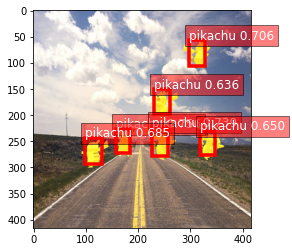

In [14]:

test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')
finetune_net = gcv.model_zoo.get_model(
    'yolo3_darknet53_custom',
    classes=classes,
    pretrained_base=False,
)
finetune_net.load_parameters('yolo3.pikachu.params')
x, image = gcv.data.transforms.presets.yolo.load_test('pikachu_test.jpg', short=416)
cid, score, bbox = finetune_net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes, thresh=.3)

plt.show()

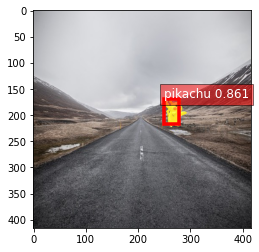

In [15]:

x = dataset[0][0]
x, image = gcv.data.transforms.presets.yolo.transform_test(x, short=416)
cid, score, bbox = finetune_net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes, thresh=.4)

plt.show()

In [43]:
net.classes

['pikachu']